# Fit to Distribution B

In [1]:
from matplotlib import pyplot as plot
from scipy.linalg import lstsq
from sympy import Symbol, log, pi, sin

from LocUtil import Grid1, LogGrid1, MinMax, SetSeed

from Dist import ExampB
from Map import LogRatio
from Mollifier import MolSetZ
from Sinc import SincD

In [2]:
nSamp = 100
nSinc = 8

givenSeed = 738

nPlot = 101

In [3]:
dist = ExampB()

## Pre-Fit Setup

### Generate Data

In [4]:
seed = SetSeed(givenSeed, digits=3)
if givenSeed is None:
	print(f'seed = {seed}')
samp = [dist.Sample() for _ in range(nSamp)]

In [5]:
sampSort = sorted(samp)
quant = [(k + 0.5) / nSamp for k in range(nSamp)]

Text(0, 0.5, 'CDF')

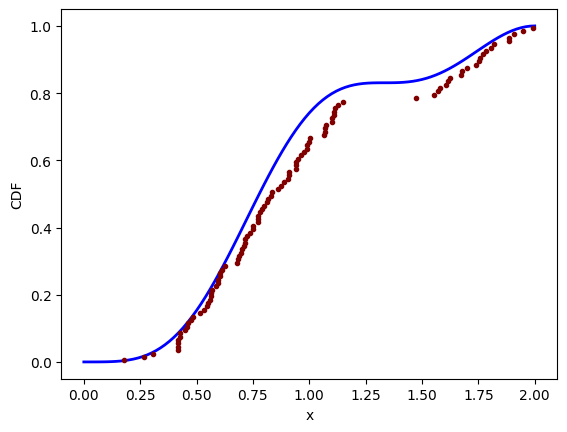

In [6]:
plot.plot(sampSort, quant, '.', c='Maroon')

xL = Grid1(0,2,nPlot)
cdfX = tuple(dist.Cdf(x) for x in xL)
plot.plot(xL, cdfX, c="blue", lw=2, zorder=-1)

plot.xlabel('x')
plot.ylabel('CDF')

### Map from x to z

In [7]:
x = Symbol('x')
z = Symbol('z')

mapGen = LogRatio(x,z, (0,2))
mapExp = mapGen.MapExp()
invExp = mapGen.InvExp()

mapExp

log(x/(2 - x))

In [8]:
sampZ = [mapExp.subs(x,xV).evalf() for xV in sampSort]

In [9]:
zMin,zMax = MinMax(sampZ)
zMin,zMax

(-2.32603265160448, 5.39113567676777)

Text(0, 0.5, 'CDF')

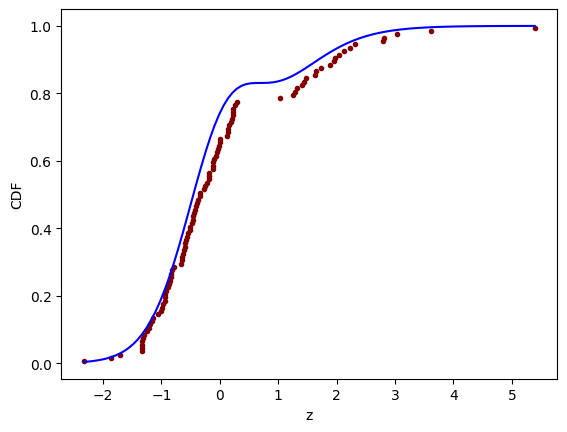

In [10]:
plot.plot(sampZ,quant, '.', c='Maroon')

zGrid = Grid1(zMin,zMax,nPlot)
cdfZ = [dist.Cdf(invExp.subs(z,zV).evalf()) for zV in zGrid]
plot.plot(zGrid,cdfZ, c='blue')

plot.xlabel('z')
plot.ylabel('CDF')

### Mollifyer

In [11]:
y = Symbol('y')
mapGenMol = LogRatio(y, z, (0, 1))

In [12]:
mapMol = mapGenMol.MapExp()
invMol = mapGenMol.InvExp()

mapMol, invMol

(log(y/(1 - y)), exp(z)/(exp(z) + 1))

In [13]:
molZ = invMol

Text(0, 0.5, 'CDF')

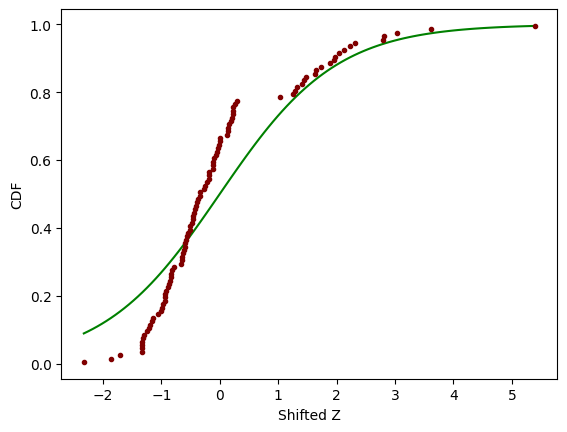

In [14]:
molL = [molZ.subs(z, zV) for zV in zGrid]
plot.plot(zGrid,molL, c='Green')

plot.plot(sampZ,quant, '.', c='Maroon')

plot.xlabel('Shifted Z')
plot.ylabel('CDF')

### Shift

In [15]:
z0 = (zMax + zMin) / 2
z0

1.53255151258164

In [16]:
zsMin = zMin - z0
zsMax = zMax - z0
zsMin,zsMax

(-3.85858416418612, 3.85858416418612)

In [17]:
sampZs = [z - z0 for z in sampZ]

Text(0, 0.5, 'CDF')

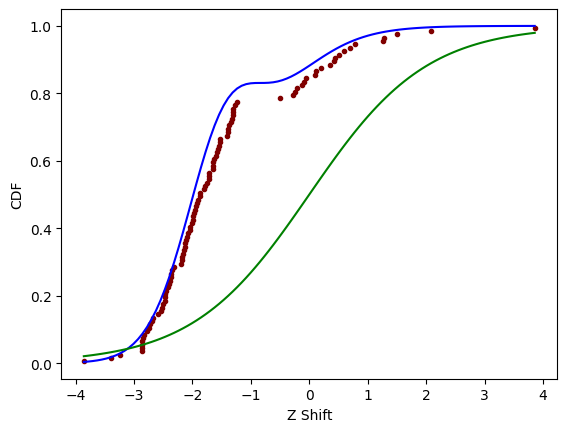

In [18]:
plot.plot(sampZs,quant, '.', c='Maroon')

zGrid = Grid1(zsMin,zsMax, nPlot)
cdfZs = [dist.Cdf(invExp.subs(z,zV + z0).evalf()) for zV in zGrid]
plot.plot(zGrid,cdfZs, c='blue')

molL = [molZ.subs(z, zV) for zV in zGrid]
plot.plot(zGrid,molL, c='Green')

plot.xlabel('Z Shift')
plot.ylabel('CDF')

### Scale

In [19]:
s = Symbol('s')

temp = molZ.subs(z, s*zsMin) - quant[0]
temp

-0.005 + exp(-3.85858416418612*s)/(1 + exp(-3.85858416418612*s))

In [20]:
temp.solve(s)

AttributeError: 'Add' object has no attribute 'solve'

In [21]:
type((molZ.subs(z, s*zsMin) - quant[0]))

sympy.core.add.Add

Need to figure out why this doesn't work sometimes but works other times'

In [22]:
scale = log(quant[0] / (1 - quant[0])) / zsMin
scale

1.37182567477856

In [23]:
molZsc = molZ.subs(z, scale*z)
molZsc

exp(1.37182567477856*z)/(exp(1.37182567477856*z) + 1)

Text(0, 0.5, 'CDF')

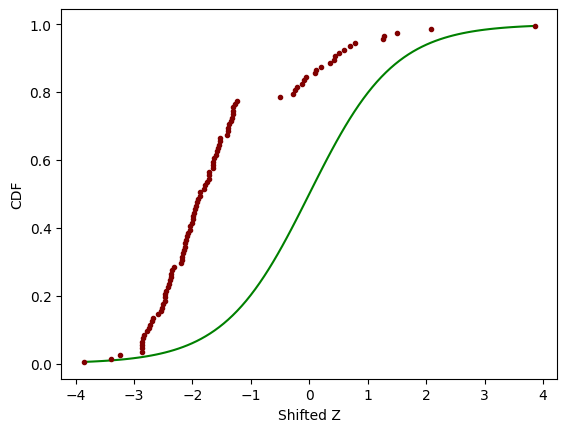

In [24]:
molL = [molZsc.subs(z, zV).evalf() for zV in zGrid]
plot.plot(zGrid,molL, c='Green')

plot.plot(sampZs,quant, '.', c='Maroon', label='Scaled Mollifyer')

plot.xlabel('Shifted Z')
plot.ylabel('CDF')

### Map for zss

In [25]:
mapGenZss = mapGen.ShiftScale(z0,scale)
mapZss = mapGenZss.MapExp()
mapZss

1.37182567477856*log(x/(2 - x)) + 2.10239351288021

In [26]:
invZss = mapGenZss.InvExp()
invZss

0.431967756168831*exp(0.728955594275068*z)/(0.215983878084415*exp(0.728955594275068*z) + 1)

### Compute Residual

Text(0, 0.5, 'Residual')

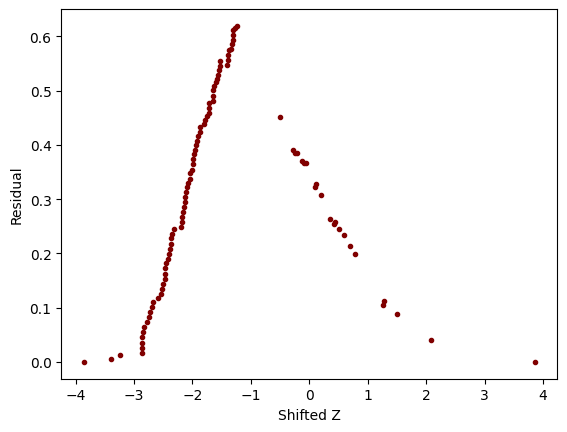

In [27]:
resZ = [q - molZsc.subs(z,zs).evalf() for (zs,q) in zip(sampZs,quant)]

plot.plot(sampZs,resZ, '.', c='Maroon')

plot.xlabel('Shifted Z')
plot.ylabel('Residual')

## Fit to Pre-Processed Data

### Compute Floating Mollify Set

The order of the mollifiers is (1,1).  This is somewhat subtle.
The derivative of the CDF is zero at y=0 (i.e., x=0) and non-zero at y=1 (i.e., x=2).
So it would seem natural to use an order of (0,1).
However, but then the modifier for the derivative at y=1 will produce a non-zero derivative at 
y=0, causing the residual to have a non-zero derivative at y=0 even though the CDF has a zero 
derivative at y=0.

In [28]:
temp = MolSetZ(z, (1,1))
temp

[(3*exp(z) + 1)/(exp(z) + 1)**3,
 exp(z)/(exp(z) + 1)**3,
 (exp(z) + 3)*exp(2*z)/(exp(z) + 1)**3,
 -exp(2*z)/(exp(z) + 1)**3]

The fixed bases are M[0,*] = 0, M[1,*] = 0, and M[*,0] = 1.
Only M[*,1] floats. 

In [29]:
molFloatZ = temp[3]
molFloatZ

-exp(2*z)/(exp(z) + 1)**3

In [30]:
molFloatY = molFloatZ.subs(z,mapMol).simplify()
molFloatY

y**2*(y - 1)

#### Check result

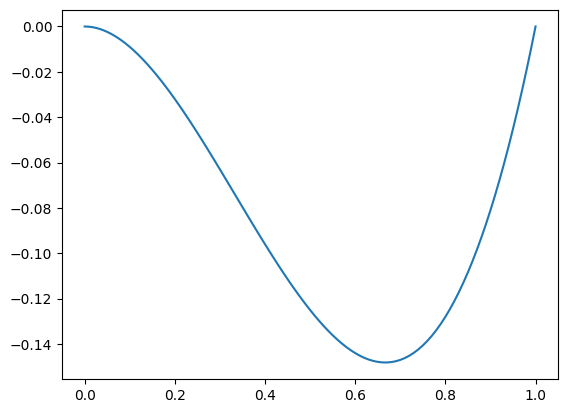

In [31]:
yGrid = Grid1(0,1, nPlot)
mol = [molFloatY.subs(y, yV).evalf() for yV in yGrid]

plot.plot(yGrid,mol)

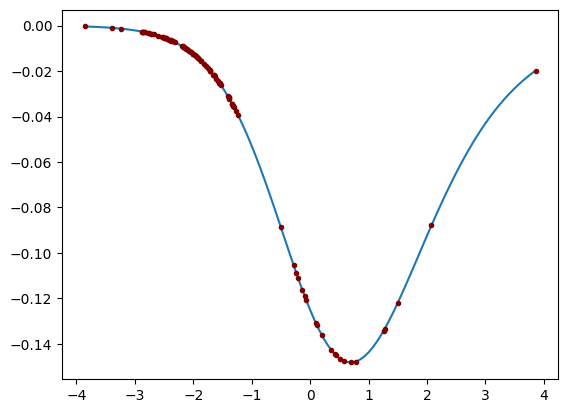

In [32]:
zGrid = Grid1(zsMin,zsMax, nPlot)
mol = [molFloatZ.subs(z, zV).evalf() for zV in zGrid]

plot.plot(zGrid,mol)

molColumn = [molFloatZ.subs(z, zV).evalf() for zV in sampZs]
plot.plot(sampZs,molColumn, '.', c='Maroon')

### Nullifyer

In [33]:
mapZsGen = mapGen.ShiftScale(z0,1)
mapZs = mapZsGen.MapExp()
mapZs

log(x/(2 - x)) + 1.53255151258164

In [34]:
invZs = mapZsGen.InvExp()
invZs

0.431967756168831*exp(z)/(0.215983878084415*exp(z) + 1)

In [35]:
nullX = mapZsGen.NullLeftX() * mapZsGen.NullRightX() ** 2 
nullX

sqrt(2)*x*(2 - x)**2/4

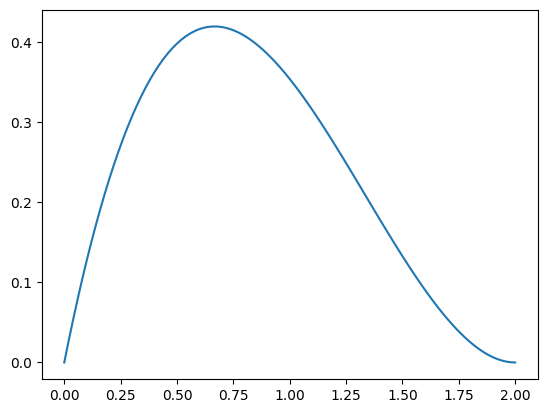

In [36]:
xGrid = Grid1(0,2,nPlot)
null = [nullX.subs(x,xV).evalf() for xV in xGrid]
plot.plot(xGrid,null)

In [37]:
nullZ = mapZsGen.NullLeftZ() * mapZsGen.NullRightZ() ** 2 
nullZ

0.431967756168831*sqrt(2)*exp(z)/(0.215983878084415*exp(z) + 1)**3

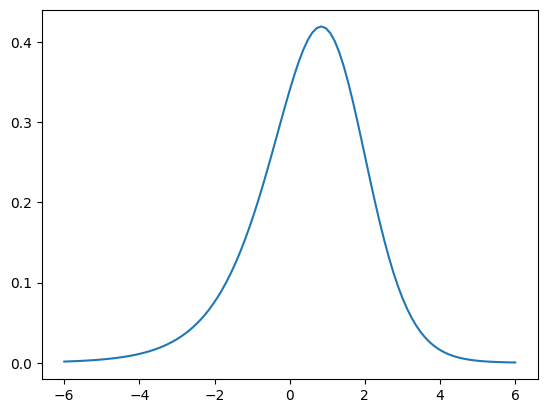

In [38]:
zGrid = Grid1(-6,6, nPlot)
null = [nullZ.subs(z,zV).evalf() for zV in zGrid]
plot.plot(zGrid,null)

TODO:  Check this graph in Maple

### Set Up Sinc Matrix

In [39]:
nSinc = 8

In [40]:
h = (zMax - zMin) / (nSinc - 1)
sincPointZ = tuple(zsMin + k*h for k in range(nSinc))
sincPointZ

(-3.85858416418612,
 -2.75613154584723,
 -1.65367892750834,
 -0.551226309169446,
 0.551226309169446,
 1.65367892750834,
 2.75613154584723,
 3.85858416418612)

In [64]:
h,scale

(1.10245261833889, 1.37182567477856)

In [65]:
invZ = mapZsGen.InvExp()
invZ

0.431967756168831*exp(z)/(0.215983878084415*exp(z) + 1)

In [43]:
sp = Symbol('sp')
base = SincD(0,(z - sp)/h) * nullZ
base

0.431967756168831*sqrt(2)*exp(z)*SincD(0, -0.907068461143244*sp + 0.907068461143244*z)/(0.215983878084415*exp(z) + 1)**3

#### Check Basis

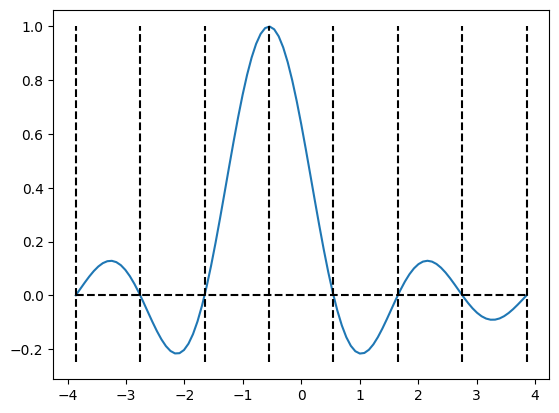

In [44]:
zGrid = Grid1(zsMin,zsMax, nPlot)
y = [SincD(0,(z - sp)/h).subs(sp,sincPointZ[3]).subs(z,zV).evalf() for zV in zGrid]

plot.plot(zGrid,y)

for spV in sincPointZ:
	plot.plot((spV,spV),(-0.25,1), '--', c='black')

plot.plot((zsMin,zsMax),(0,0), '--', c='black')

In [45]:
rhs = []
mat = []

for (zV,res) in zip(sampZs,resZ):
	molV = float(molFloatZ.subs(z, zV).evalf())
	sincRow = [float(base.subs({z:zV, sp:spV}).evalf()) for spV in sincPointZ]

	row = [molV] + sincRow
	mat.append(row)
	
	rhs.append(float(res))

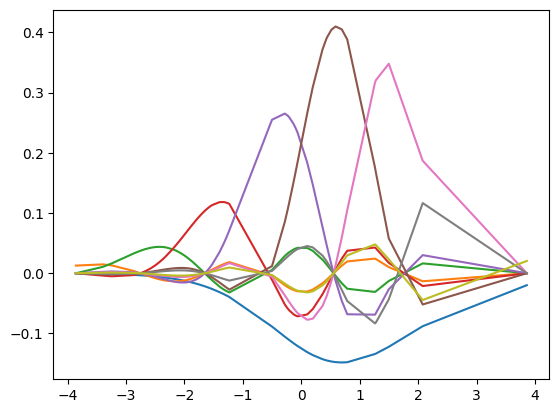

In [46]:
for colNum in range(nSinc + 1):
	y = [mat[k][colNum] for k in range(nSamp)]
	plot.plot(sampZs,y)

In [47]:
  temp, _, _, _ = lstsq(mat, rhs)
  weight = tuple(temp)
  weight

(-3.407770364308428,
 -0.8006008857862511,
 1.751531739697238,
 4.149934452410748,
 0.7843270357449528,
 -0.6411689921262586,
 -0.9340138266128547,
 -2.063812222954688,
 -3.3151430553000094)

### interpolate only the residual on Z

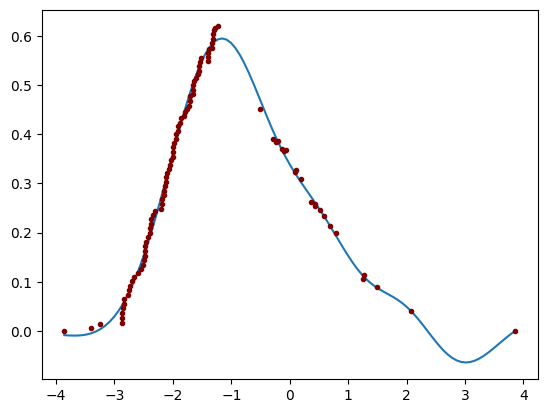

In [48]:
gridZ = Grid1(zsMin,zsMax, nPlot)
gridRes = []

for zV in gridZ:
	val = weight[0] * molFloatZ.subs(z,zV).evalf()
	for k in range(nSinc):
		val += weight[k + 1] * base.subs(z,zV).subs(sp, sincPointZ[k]).evalf()
	
	gridRes.append(val)

plot.plot(gridZ,gridRes)

plot.plot(sampZs, resZ, '.', c='maroon')

The symbolic setup is slower than it should be, probably too slow for large 3D problems

### full interpolate (i.e., including mollifier) on Z

Text(0, 0.5, 'CDF')

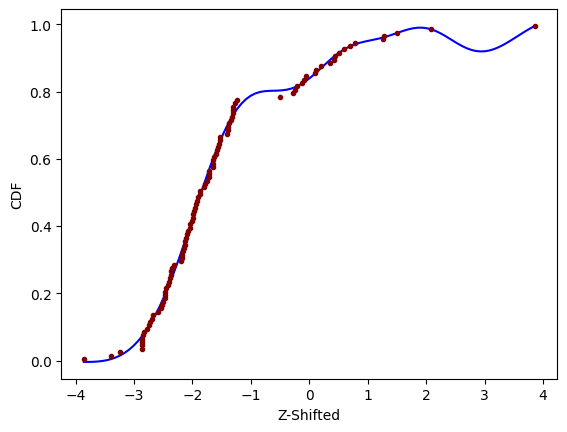

In [49]:
gridCdf = [gridRes[k] + molZsc.subs(z,gridZ[k]).evalf() for k in range(nPlot)]
plot.plot(gridZ, gridCdf, c='blue')

plot.plot(sampZs, quant, '.', c='maroon')

plot.xlabel('Z-Shifted')
plot.ylabel('CDF')

### full interpolate on x

TODO:  Once the sinc-interpolation function is tested, use interpolate on a grid in X
TODO: There is a bug in *invZs* it is subtracting z0 rather than adding it

Text(0, 0.5, 'CDF')

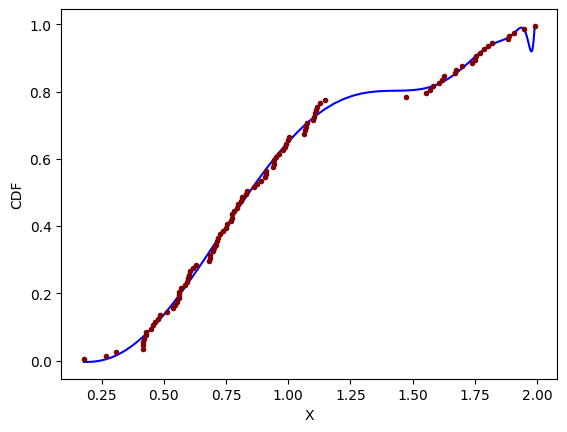

In [50]:
gridX = [invExp.subs(z, zV + z0) for zV in gridZ]

plot.plot(gridX, gridCdf, c='blue')
plot.plot(sampSort, quant, '.', c='maroon')

plot.xlabel('X')
plot.ylabel('CDF')

## compute PDF from CDF

In [ ]:
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> working here

gridZ = Grid1(zsMin,zsMax, nPlot)
gridRes = []

for zV in gridZ:
	val = weight[0] * molFloatZ.subs(z,zV).evalf()
	for k in range(nSinc):
		val += weight[k + 1] * base.subs(z,zV).subs(sp, sincPointZ[k]).evalf()
	
	gridRes.append(val)

plot.plot(gridZ,gridRes)

plot.plot(sampZs, resZ, '.', c='maroon')